# Neural Network from Scratch
Following [this](https://heartbeat.fritz.ai/building-a-neural-network-from-scratch-using-python-part-1-6d399df8d432) tutorial.

In [1]:
# import everything
import csv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # suppress warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
import math

## Get data

In [2]:
# prepare data download from UCL
import csv
import pandas as pd

# add header names
headers = [
    'age','sex','chest_pain','resting_blood_pressure','serum_cholestoral',
    'fasting_blood_sugar','resting_ecg_results','max_heart_rate_achieved',
    'exercise_induced_angina','oldpeak','slope of the peak',
    'num_of_major_vessels','thal','heart_disease'
]

heart_df = pd.read_csv('heart.dat', sep=' ', names=headers)

In [3]:
heart_df

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


In [4]:
heart_df.shape

(270, 14)

## Check for missing values and check data types

In [5]:
# neural net needs all features to be numeric
heart_df.isna().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate_achieved    0
exercise_induced_angina    0
oldpeak                    0
slope of the peak          0
num_of_major_vessels       0
thal                       0
heart_disease              0
dtype: int64

In [6]:
heart_df.dtypes

age                        float64
sex                        float64
chest_pain                 float64
resting_blood_pressure     float64
serum_cholestoral          float64
fasting_blood_sugar        float64
resting_ecg_results        float64
max_heart_rate_achieved    float64
exercise_induced_angina    float64
oldpeak                    float64
slope of the peak          float64
num_of_major_vessels       float64
thal                       float64
heart_disease                int64
dtype: object

## Split data into train and test sets, then standardise

In [7]:
# convert input to numpy arrays
X = heart_df.drop(columns=['heart_disease']) # predicting heart disease

# replace target class with 0 and 1
# 1 = 'have heart disease', 0 = 'no heart disease'
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1, 0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2, 1)

y_label = heart_df['heart_disease'].values.reshape(X.shape[0], 1)

# split data into tran and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, 
                                               random_state=2)

# standardise dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f'Shape of train set is {Xtrain.shape}')
print(f'Shape of test set is {Xtest.shape}')
print(f'Shape of train label is {ytrain.shape}')
print(f'Shape of test labels is {ytest.shape}')

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


## Building the network
The neural network is comprised of multiple layers. Each layer is a collection of nodes. Each node acts as a neuron and performs calculations on the data passed to it. Here's an exmaple of a 3-layer neural network below:

![Img Alt Text](https://miro.medium.com/max/700/1*Z3zHoX1nhK6Rsmd4yNPdsg.jpeg)

Although there are technically 4 layers, the first layer is not counted. The first layer is the **input layer**, and the number of nodes in this layer will depend on the number of features present in your dataset. In our case it will be 13 nodes (because we have 13 features).

The final layer of the neural network is called the **output layer**, and the number of nodes depends on what you're trying to predict. For regression and binary classification tasks, a single node will do; while for multi-class problems, multiple nodes are needed (depending on the number of classes).

Our task is **binary classification** (i.e. the patient either has a heart disease or not).

The layers between the input and final layers are called the **hidden layers**. The hidden layers can be as deep and/or wide as you want, but although a deeper network is better, it becomes more computationally expensive.

To keep things simple in this tutorial, we'll have 1 hidden layer with 8 nodes to create a 2-layer network:

![Img Alt Text](https://miro.medium.com/max/586/1*tDZCZM0g5oJxyZ0JfqRJDQ.png)

## Weights and Biases
The weights and biases are the learnable/adjustable parameters which optimise the neural network. Think of it like this:  
- Weights: how sure you are that a feature contributes to a prediction.  
- Biases: base value that your predictions must start from.

Let's go through an example:  
Assume you're a machine learning model, and the goal is to predict whether a person is rich or not, and you've been the following clues (*features*) to help with the decision:
- Age
- Height
- Salary

The clues above are called the **features** and what you want to predict is the **target** (a.k.a. label/ground truth). In this example the label can be one of two classes (rich, not rich) - in other words, ***binary classification***. Basically, you want to combine the features in such an equation that they help with accurately predicting the outcome.

<br>
<center>$y(rich, not rich) = Age + Height + Salary + [base]$</center>

<br>
Let's assume a base salary of \$3000, and Person 1 has the following features; age = 18, height = 5.6ft, salary = \$2000, then you'll calculate richness as follows:
<br>
<br>
<center>$y(rich, not rich) = 18 + 5.6 + 2000 + 3000 =  \sim5024$</center>

<br>
For this example, we might define a threshold for richness as any value greater than \$40,000. Judging by these criteria, we might conclude that Person 1 is not rich. Let's look at another example:

Person 2 has the following features; age = 26, height = 5.2ft, salary = \$50,000. The prediction will be calculated as:

<br>
<center>$y(rich, not rich) = 26 + 5.2 + 50000 + 3000 = \sim53,031$</center>

<br>
Then by the threshold stated earlier, Person 2 is rich.

Obvioucly some clues are more important than others (Salary), and others are less important (Age and Height). With this idea, we can assign importance to features. For example, we can assign the following *weights*:

<center>$y(rich, not rich) = (2\times Age) + (1\times Height) + (8\times Salary) + base$</center>

<br>
Intuitively, we assign a higher value to the salary feature. The importance of the value can be any number but must be representative of scale. The base value of 3000 is called the **bias** - it's a base value that every prediction must have, even when nothing else is given.

Now if you make a prediction for Person 1 and 2 again, you'll have the following:

<br>
Person 1: $(2\times 18)+(1\times 5.6)+(8\times 2000)+3000=\sim 19,041$ (still poor)
<br>
<br>
Person 2: $(2\times 26)+(1\times 5.2)+(8\times 5000)+3000=\sim 43,057$ (still rich)

If a person has no value for age, height and salary then the prediction will be the base value. This is need for bias. What you should take away from this is:
- Weights: values assigned to features
- Biases: Base value

A machine learning model uses lots of data to learn the correct weights and biases to assign each feature in a dataset to correctly predict outputs.

Back to the tutorial example, you now know that every feature in the dataset must be assigned a weight and that after doing a weighted sum, a bias term is added. This is done in the class below:

In [26]:
class NeuralNet():
    '''
    A two layer neural network
    '''
    
    def __init__(self, layers=[13,8,1], learning_rate=0.001, 
                 iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
    
    def init_weights(self):
        '''
        Initialise the weights from a random normal distribution
        '''
        np.random.seed(1) # seed the random number generator
        self.params['W1'] = np.random.randn(self.layers[0], self.layers[1])
        self.params['b1'] = np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1], self.layers[2])
        self.params['b2'] = np.random.randn(self.layers[2])

First, you create a nerual network class, and during initialisation you create some variables to hold intermediate calculations. You'll notice `layers` matches the dimensions of the neural network we will be building. We'll talk about `learning_rate`, `iterations` and `sample_size` later.

Next, you created a function `init_weights()` to initialise the weights and biases as random numbers. These weights are initialised from a random normal distribution and saved to a dictionary called **`params`**.

You'll notice there are two weight and bias arrays. The first weight array `W1` will have dimensions of 13 by 8 - this is because you have 13 input features and 8 hidden nodes, while the first bias `b1` will be a vector of size 8 because you have 8 hidden nodes.

The second weight array `W2` will be a 8 by 1-dimensional array because you have 8 hidden nodes and 1 output node, and finally the second bias `b2` will be a vector of size 1 because you have just 1 output.

Here's an image to illustrate what's happening at each node:

![Img Alt Text](https://gblobscdn.gitbook.com/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvI8vNq_N7u3RWVAPLk%2F-LvJSdcFXzoI-WW0L3w5%2Fimage.png?alt=media&token=84526dc6-4634-4de5-aacf-00a179afac76)

In general for an n-layer architecture, you will have n arrays of weights and n biases at each layer (excluding the input layer).

## The Activation Function
Now that weights and biases have been initialised, let's talk about activation functions.

***Activations*** *are the nonlinear computations done in each node of a Neural Network.*

Remember when I said each node performs a mathematical computation? Well, that happens in two phases:

First, you do a weighted sum of the input and the weights, add the biases, and then pass the result through an activation function. Why? Keep reading...

An activation function is what makes a neural network capable of learning complex non-linear functions. Non-linear functions are difficult for traditional machine learning algorithms (like logistic and linear regression) to learn. The activation function is what makes a neural network capable of understanding these functions.

There are many types of activation functions used in deep learning. Each function has its pros and cons, but the ReLU function has been shown to perform very well, so let's use that.

![Img Alt Text](https://miro.medium.com/max/700/1*ZafDv3VUm60Eh10OeJu1vw.png)

The activation function is computed by each node in the hidden layers of a neural network. This means you'll have to pass the weighted sums through the ReLU function for every node in the hidden layers.

But what is ReLU?

ReLU (Rectified Linear Unit) is a simple function that compares a value with zero. That is, it will return the value passed to it if it is greater than zero; otherwise it returns zero.

In [27]:
# method to be added to Neural Network class
class NeuralNet1(NeuralNet):
    def __init__(self, *args):
        NeuralNet.__init__(self, *args)
    
    def relu(self, Z):
        '''
        The ReLU activation function is to perform a threshold
        operation to each input element where negative values
        are set to zero.'''
        return np.maximum(0, Z)

The `relu()` function is to be added to the `NeuralNet` class (here I extended the original class to add the method - the full class will be at the very bottom). This function performs an array-wise ReLU because you'll be dealing mainly with arrays, not single values.

In summary, the hidden layers receives values from the input layer, calculates a weighted sum, adds the bias term, and then passes each result through an activation function - in our case a ReLU. The result from the ReLU is then passed to the output layer, where another weighted sum is performed using the second weights and biases. but then instead of passing the result through another activation function, it is passed through an output function.

The output function will depend on what you're trying to predict. You can use a sigmoid function when you have a two-class problem (binary classification), and you can use a function called softmax for multi-class problems.

In this tutorial, we'll be using the sigmoid function for the output layer. This is because you're predicting one of two classes.

![Img Alt Text](https://miro.medium.com/max/640/1*OUOB_YF41M-O4GgZH_F2rw.png)

The sigmoid function takes a real number and squashes it to a value between 0 and 1. In other words, it outputs a probability score for every real number. This is useful for the task at hand because you don't just want your model to predict a yes (1) or no (0) - you want it to predict probabilities that can help you measure how sure it is of its predictions.

Let's add the sigmoid function to our `NeuralNet` class:

In [37]:
class NeuralNet2(NeuralNet1):
    def __init__(self, *args):
        NeuralNet1.__init__(self, *args)
        
    def sigmoid(self, Z):
        '''
        The sigmoid function takes in real numbers in any range and
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

The numpy exponential function is used as it is now possible to perform the operation for arrays instead of single values. Also, Numpy implementation is faster than pure Python, as it's written in C.

## The Loss Function
The loss function is a way of measuring how good a model's prediction is so that it can adjust the weights and biases.

A loss function must be properly designed so that it can correctly penalise a model that is wrong and reward a model that is right. This means that you want the loss to tell you if a prediction made is far or close to the true prediction.

The choice of the loss function is dependent on the task - and for classification problems, you can use cross-entropy loss.
<br>
<br>
<font size="5"><center>$CE=-\sum_{i}^C y_i\log{(\hat{y}_i)}$</center></font>

Where:
- $C$ = number of classes
- $y_{i}$ = true value
- $\hat{y}_{i}$ = predicted value  

For a binary classification task (i.e. $C=2$), the cross-entropy loss function becomes:

<font size="4"><center>$CE=-\sum_{i=1}^2 y_1\log{(\hat{y})}=-y_1\log{(\hat{y}_1)}-(1-y_1)\log{(1-\hat{y}_1)}$</center></font>

Let's put this into code:

In [38]:
# if NN supplies 0 values to log, it will result in infinity, which will 
# affect network training. So here, compare value and if it is zero, 
# replace it with an extremely small value
class NeuralNet3(NeuralNet2):
    def __init__(self, *args):
        NeuralNet2.__init__(self, *args)
        
    def eta(self, x):
        ETA = 0.0000000001
        return np.maximum(x, ETA)
    
    def entropy_loss(self, y, y_hat):
        nsample = len(y)
        y_hat_inv = 1.0 - y_hat
        y_inv = 1.0 - y
        y_hat = self.eta(y_hat_inv) # clips value to avoid NaNs in log
        y_hat_inv = self.eta(y_hat_inv)
        
        loss = -1/nsample * (
            np.sum(np.multiply(np.log(y_hat), y) + 
                   np.multiply((y_inv), np.log(y_hat_inv))
                  )
        )
        return loss

Notice the sum and division by sample size? This means you're considering the average loss with respect to all the inputs. That is, you're concerned about the combined loss from all the samples and not the individual losses.

## Going Forward: Forward Propagation
Forward propagation is the name given to the series of computations performed by the neural network before a prediction is made. In our two-layer network, we'll perform the following computation for forward propagation:
- Compute the weighted sum between the input and first layer's weights and then add the bias: $Z_1=(W_1\times X)+b$
- Pass the result through the ReLU activation function: $A_1=relu(Z_1)$
- Compute the weighted sum between the output ($A_1$) of the previous step and the second layer's weights - also add the bias: $Z_2=(W_2\times A_1)+b_2$
- Compute the output function by passing the result through a sigmoid function: $A_2=\sigma(Z_2)$
- And finally, compute the loss between the predicted output and the true labels: $loss(A_2, Y)$

![Img Alt Text](neural-net-diagram.png)

Where:  
$a_0=relu((x_0\times w_{0_{1,1}})+b_{0_1})$  
$y0=\sigma((a0\times w_{1_1})+b)$

And there, you have the forward propagation for your two-layer neural network. For a three-layer network, you'd have to compute the $Z_3$ and $A_2$ using $W_3$ and $b_3$ before the output layer.

Now let's add the code.

In [39]:
class NeuralNet4(NeuralNet3):
    def __init__(self, *args):
        NeuralNet3.__init__(self, *args)
        
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        y_hat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y, y_hat)
        
        # save calculated parameters
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1
        
        return y_hat, loss

In the code above, first you perform all the dot products and additions using the weights and biases you initialised earlier, calculate the loss by calling the `entropy_loss()` method, save the calculated parameters and finally return the predicted values and loss. These values will be used during backpropagation.

## A Step Backward: Backpropagation
Backpropagation is the name given to the process of training a neural network by updating its weights and biases.

A neural networks learns to predict the correct values by continuously trying different values for the weights and then comparing the losses. If the loss function decreases, then the current weight is better than the previous, or vice versa. This means that the neural net has to go through many training (forward propagation) and update (backpropagation) cycles in order to get the optimal weights and biases. This cycle is generally referred to as the training phase, and the process of searching for the right weights is called optimisation.

To correctly adjust the weights with respect to the loss the neural network calculates, you make use of calculus.

### Using Calculus in Backpropagation
After computing the output and loss in the forward propagation layer, you'll move to the backpropagation phase, where you calculate the derivatives backward, from the loss all the way up to the first weight and bias. To perform backpropagation in your neural network, you'll follow the steps listed below:

Starting from the last layer, calculate the derivative of the loss with respect to the ouput $\hat{y}$ as:

<font size="6"><center>$\frac{dl}{d\hat{y}}=\frac{-y}{\hat{y}}+\frac{1-y}{1-\hat{y}}$</center></font>

But how did you get the loss? Well, you calculated $\sigma(Z_2)$. Now, what is the derivative of the loss with respect to $\sigma(Z_2)$?

$\sigma(Z_2)$ is a combination of two functions, so you have to calculate two derivatives:

First, calculate the derivative of sigmoid activation with respect to (w.r.t) the loss:
<br><br>
<font size="5">
    <center>
        $
        \frac{d\sigma}{dl}=\sigma(x)\times (1.0-\sigma(x))
        $
    </center>
</font>

Then, you calculate the derivative of the loss w.r.t $Z_2$:
<br><br>
<font size="5">
    <center>
        $
        \frac{dl}{dZ_2}=\frac{dl}{d\hat{y}}\times\frac{d\sigma}{dl}
        $
    </center>
</font>

Now, how did you get Z2? You calculated a dot product between $A_1$ and $W_2$, and added a bias $b_2$. This means that you have to calculate the loss with respect to all these variables.
<br><br>
<font size="5">
    <center>
        $
        \frac{dl}{dA_1}=W_2\times\frac{dl}{dZ_2}
        $ <br><br>
        $
        \frac{dl}{dW_2}=A_1\times\frac{dl}{dA_1}
        $ <br><br>
        $
        \frac{dl}{db_2}=\frac{dl}{dZ_2}
        $
    </center>
</font>

And how did you get to $A_1$? You performed $ReLU(Z_1)$. So you take the derivative of $ReLU$ and $Z_1$ w.r.t the loss as well. The derivative of ReLU is 1 if the input is greater than 1, and 0 otherwise.

You'll create a function to compute this and call it `dRelu`:
<br><br>
<font size="5">
    <center>
        $
        \frac{dl}{dRelu}=dRelu
        $ <br>
        $
        \frac{dl}{dZ_1}=\frac{dl}{dA_1}\times dRelu
        $
    </center>
</font>

Next, how did you get $Z_1$? You computed the dot product between $X$ and $W_1$ and added the bias $b_1$. So you compute the derivate of all these variables, except the input $X$.
<br><br>
<font size="5">
    <center>
        $
        \frac{dl}{dW_1}=X\times\frac{dl}{dZ_1}
        $ <br>
        $
        \frac{dl}{db_1}=\frac{dl}{dZ_1}
        $
    </center>
</font>

For a detailed overview of hose these derivatives are calculated from scratch, [this post](https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60) is good.

Let's write the code.

In [42]:
class NeuralNet5(NeuralNet4):
    def __init__(self, *args):
        NeuralNet4.__init__(self, *args)
        
    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def back_propagation(self, y_hat):
        '''
        Computes the derivatives and update the weights and bias 
        accordingly.
        '''
        y_inv = 1 - self.y
        y_hat_inv = 1 - y_hat
        
        dl_wrt_yhat = np.divide(y_inv, self.eta(y_hat_inv)) - np.divide(self.y, self.eta(y_hat))
        dl_wrt_sig = y_hat * (y_hat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig
        
        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)
        
        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)
        
        # update the weights and biases
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

## Optimisation and Training of the Neural Network
In the above cell, we used calculus to compute the derivatives of the weights and biases with respect to the loss. The model now knows how to change them. In the training phase, the neural network must perform the following:
- Forward propagation
- Backpropagation
- Weight updates and calculated gradients
- Repeat  

What we're doing at the end of the cell is subtracting the derivative multiplied by a small value called the *learning rate* - a value which tells the network how big the update should be (our default value is 0.001).

Now that we've added code to update the weights, let's make a new function called `fit()` which takes the input (X) and labels (Y) and calls the forward and backpropagation repeatedly for a specified number of iterations:

In [62]:
class NeuralNet6(NeuralNet5):
    def __init__(self, *args):
        NeuralNet5.__init__(self, *args)
    
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights()  # initalise weights and biases
        
        current_time = time.strftime("%H:%M:%S", time.localtime())
        print(f'Start time: {current_time}')
        for i in range(self.iterations):
            # print progress
            portion_done = i / self.iterations
            bars = round(portion_done*20)
            print(f'[{"="*bars}{" "*(20-bars)}]\t{round(portion_done*100)}%', end='\r')
            
            # fit
            y_hat, loss = self.forward_propagation()
            self.back_propagation(y_hat)
            self.loss.append(loss)

The `fit()` method takes 2 parameters: X (input dataset) and y (labels). First, it saves the train and target to the class variable and then initialises the weights and biases by calling the `init_weights()` function. Then it loops through the specified number of iterations, performs forward and backpropagation, and saves the loss.

## Making Predictions
To make predictions, you simply make a forward pass on the test data, i.e. you use the saved weights and biases from the training phase. To make the process easier, let's add a function to do it:

In [64]:
class NeuralNet7(NeuralNet6):
    def __init__(self, *args):
        NeuralNet6.__init__(self, *args)
        
    def predict(self, X):
        '''
        Predicts on a test datapoint
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)

The function passes the forward propagation and returns the final value (i.e. the prediction). The predictions are probability values between 0 and 1 (because of the sigmoid function). In order to interpret these probabilities, you can either round up the values or use a threshold function. To keep things simple, we just rounded up the probabilities.

## Putting It Together
Here's all the code:

In [29]:
class NeuralNet():
    '''
    A two layer neural network
    '''
    
    def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
    
    def init_weights(self):
        '''
        Initialise the weights from a random normal distribution
        '''
        np.random.seed(1) # seed the random number generator
        self.params['W1'] = np.random.randn(self.layers[0], self.layers[1])
        self.params['b1'] = np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1], self.layers[2])
        self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu(self, Z):
        '''
        The ReLU activation function is to perform a threshold
        operation to each input element where negative values
        are set to zero.'''
        return np.maximum(0, Z)
    
    def sigmoid(self, Z):
        '''
        The sigmoid function takes in real numbers in any range and
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))
    
    def eta(self, x):
        ETA = 0.0000000001
        return np.maximum(x, ETA)
    
    def entropy_loss(self, y, y_hat):
        nsample = len(y)
        y_hat_inv = 1.0 - y_hat
        y_inv = 1.0 - y
        y_hat = self.eta(y_hat) # clips value to avoid NaNs in log
        y_hat_inv = self.eta(y_hat_inv)
        
        loss = -1/nsample * (
            np.sum(np.multiply(np.log(y_hat), y) + 
                   np.multiply((y_inv), np.log(y_hat_inv))
                  )
        )
        return loss
    
    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        y_hat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y, y_hat)
        
        # save calculated parameters
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1
        
        return y_hat, loss
    
    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def back_propagation(self, y_hat):
        '''
        Computes the derivatives and update the weights and bias 
        accordingly.
        '''
        y_inv = 1 - self.y
        y_hat_inv = 1 - y_hat
        
        dl_wrt_yhat = np.divide(y_inv, self.eta(y_hat_inv)) - np.divide(self.y, self.eta(y_hat))
        dl_wrt_sig = y_hat * (y_hat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig
        
        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)
        
        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)
        
        # update the weights and biases
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2
    
    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights()  # initalise weights and biases
        
        current_time = time.strftime("%H:%M:%S", time.localtime())
        print(f'Start time: {current_time}')
        for i in range(self.iterations):
            # print progress
            portion_done = i / self.iterations
            bars = round(portion_done*20)
            print(f'[{"="*bars}{" "*(20-bars)}]\t{round(portion_done*100)}%', end='\r')
            
            # fit
            y_hat, loss = self.forward_propagation()
            self.back_propagation(y_hat)
            self.loss.append(loss)
        
    def predict(self, X):
        '''
        Predicts on a test datapoint
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)
    
    def acc(self, y, y_hat):
        '''
        Calculates the accuracy between the predicted values and the
        truth labels
        '''
        acc = int(sum(y == y_hat) / len(y) * 100)
        return acc
    
    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel('Iteration')
        plt.ylabel('logloss')
        plt.title('Loss curve for training')
        plt.show()

## Training and Testing the Neural Network
We've already preprocessed our heart disease data and split it into train and test sets so we're ready to train and test the neural network.

Start time: 17:26:11


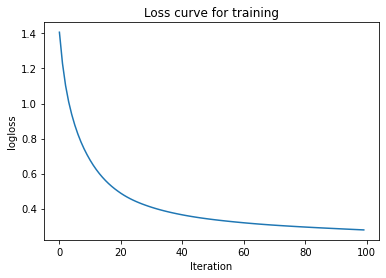

In [48]:
nn = NeuralNet(layers=[13,8,1], learning_rate=0.001, iterations=100)
nn.fit(Xtrain, ytrain)  # train the model
nn.plot_loss()

In [49]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print(f'Train accuracy is {nn.acc(ytrain, train_pred)}%')
print(f'Test accuracy is {nn.acc(ytest, test_pred)}%')

Train accuracy is 87%
Test accuracy is 75%


Start time: 17:26:28


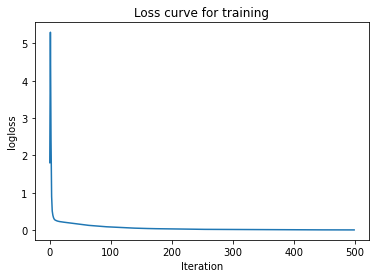

Train accuracy is 100%
Test accuracy is 70%


In [51]:
nn = NeuralNet(layers=[13,10,1], learning_rate=0.01, iterations=500)
nn.fit(Xtrain, ytrain)
nn.plot_loss()

train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print(f'Train accuracy is {nn.acc(ytrain, train_pred)}%')
print(f'Test accuracy is {nn.acc(ytest, test_pred)}%')

As shown, although the plot shows a lower loss in the second model, the test accuracy in the second plot is actually worse than the first. This implies the second model is overtrained.

BUT... these are *really* good results for a Neural Network built from scratch!

## Play area
Feel free to make new models here and play around with parameters.

Start time: 17:30:01


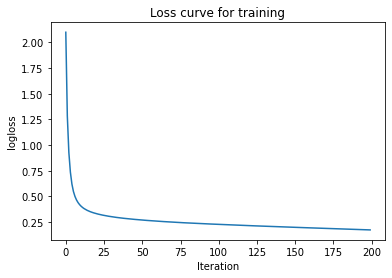

Train accuracy is 94%
Test accuracy is 74%


In [65]:
nn = NeuralNet(layers=[13, 20, 1], learning_rate=0.001, iterations=200)
nn.fit(Xtrain, ytrain)
nn.plot_loss()

train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

print(f'Train accuracy is {nn.acc(ytrain, train_pred)}%')
print(f'Test accuracy is {nn.acc(ytest, test_pred)}%')